# Week 10: Data exploration & Replication of baseline method

In [34]:
# Import necessary packages
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn
import nltk

In [35]:
# Read in the data
df_attributes = pandas.read_csv('DATA/attributes.csv')
df_products = pandas.read_csv('DATA/product_descriptions.csv')
df_train = pandas.read_csv('DATA/train.csv', encoding='latin1')
df_test = pandas.read_csv('DATA/test.csv', encoding='latin1')

In [36]:
# Data exploration
print(df_train.info())
print(df_train.shape)
print(len(df_train['product_title'].unique()))
print(df_train['product_title'].value_counts().head(10))
print(df_train['relevance'].mean(), df_train['relevance'].median(), df_train['relevance'].std())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74067 non-null  int64  
 1   product_uid    74067 non-null  int64  
 2   product_title  74067 non-null  object 
 3   search_term    74067 non-null  object 
 4   relevance      74067 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
None
(74067, 5)
53489
product_title
Lithonia Lighting All Season 4 ft. 2-Light Grey T8 Strip Fluorescent Shop Light                                          21
Pressure-Treated Timber #2 Southern Yellow Pine (Common: 4 in. x 4 in. x 8 ft.; Actual: 3.56 in. x 3.56 in. x 96 in.)    21
2 in. x 4 in. x 96 in. Premium Kiln-Dried Whitewood Stud                                                                 18
Ryobi ONE+ 18-Volt Lithium-Ion Ultimate Combo Kit (6-Tool)                                                        

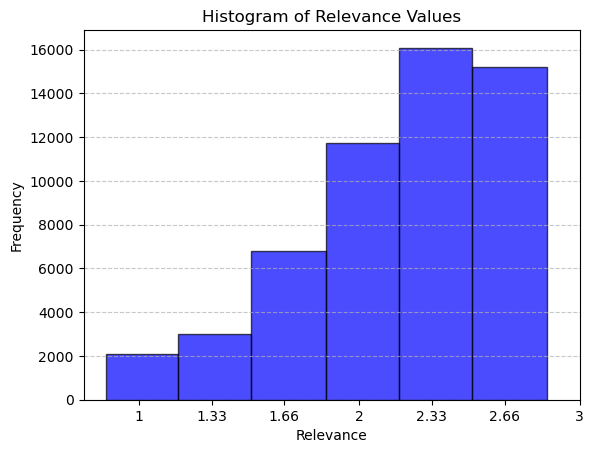

In [39]:
# Make a histogram of the relevance values
bins = [1, 1.33, 1.66, 2, 2.33, 2.66, 3]

plt.hist(df_train['relevance'], bins=np.array(bins) - 0.15, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(bins, labels=[str(b) for b in bins])

plt.title('Histogram of Relevance Values')
plt.xlabel('Relevance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
# Find the brand names
print(df_attributes['product_uid'].value_counts().head(5))
filtered_df = df_attributes[df_attributes["name"].str.contains('Brand Name', na=False)]
print(filtered_df["value"].unique())
print(filtered_df["value"].value_counts().head(10))

product_uid
195932.0    88
100532.0    80
119037.0    79
186482.0    79
144095.0    78
Name: count, dtype: int64
['Simpson Strong-Tie' 'BEHR Premium Textured DeckOver' 'STERLING' ...
 'Woolite' "Durham's Rock Hard" 'Variflex']
value
Unbranded                     2954
Hampton Bay                   1723
KOHLER                        1389
Everbilt                      1381
Home Decorators Collection    1275
GE                             987
Prime-Line                     931
Crown Bolt                     878
Delta                          853
DEWALT                         675
Name: count, dtype: int64


In [ ]:
# Baseline model from Yao-Jen Chang
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('DATA/test.csv', encoding="ISO-8859-1")
# df_attr = pd.read_csv('DATA/attributes.csv')
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')

num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

   id  product_uid  relevance  len_of_query  word_in_title  \
0   2       100001       3.00             2              1   
1   3       100001       2.50             2              1   
2   9       100002       3.00             2              1   
3  16       100005       2.33             3              1   
4  17       100005       2.67             3              3   

   word_in_description  
0                    1  
1                    1  
2                    1  
3                    1  
4                    2  
       id  product_uid  relevance  len_of_query  word_in_title  \
74067   1       100001        NaN             3              0   
74068   4       100001        NaN             3              1   
74069   5       100001        NaN             3              1   
74070   6       100001        NaN             3              2   
74071   7       100001        NaN             4              2   

       word_in_description  
74067                    1  
74068                 

# Week 11

In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

## Adjusted baseline model

In [49]:
# Adjusted baseline model
stemmer = SnowballStemmer('english')

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('DATA/test.csv', encoding="ISO-8859-1")
# df_attr = pd.read_csv('DATA/attributes.csv')
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')

num_train = df_train.shape[0]

# Function to stem words and find common words
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

# Concatenate train and test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

RMSE:  0.4817214529959809


In [50]:
# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

print(df_train.shape)

RMSE:  0.4817214529959809
(74067, 6)


In [ ]:
# Adjusted baseline model (without stemming)
stemmer = SnowballStemmer('english')

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('DATA/test.csv', encoding="ISO-8859-1")
# df_attr = pd.read_csv('DATA/attributes.csv')
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')

num_train = df_train.shape[0]

# Function to stem words and find common words
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

# Concatenate train and test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].astype(str)
df_all['product_title'] = df_all['product_title'].astype(str)
df_all['product_description'] = df_all['product_description'].astype(str)

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

RMSE:  0.512613133984399


## Feature 1: TF IDF Vectorizer

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')

df_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')

# Select relevant text features for TF-IDF
text_features = df_all[['search_term', 'product_title', 'product_description']].fillna("")

# Apply TF-IDF to capture text importance
vectorizer = TfidfVectorizer(max_features=2500, stop_words='english', lowercase=True, min_df=4)
tfidf_matrix = vectorizer.fit_transform(text_features['search_term'] + " " + text_features['product_title'] + " " + text_features['product_description'])

# Convert to DataFrame
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=vectorizer.get_feature_names_out())

# Concatenate TF-IDF features with original numerical features
df_all_tfidf = pd.concat([df_all.drop(['search_term', 'product_title', 'product_description'], axis=1), tfidf_df], axis=1)

# Split the training data into training and test sets with TF-IDF features
X_train, X_test, y_train, y_test = train_test_split(df_all_tfidf.drop(['id', 'relevance'], axis=1), df_all_tfidf['relevance'], test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE with TF-IDF
print("RMSE after TF-IDF: ", root_mean_squared_error(y_test, y_pred))


c:\Users\sanna\anaconda3\envs\DS3\Lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\sanna\anaconda3\envs\DS3\Lib\site-packages\sklearn\utils\validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RMSE after TF-IDF:  0.5225794736088272


## Feature 2: Jaccard similarity

In [ ]:
from sklearn.metrics import jaccard_score

# Create a function to calculate Jaccard Similarity
def jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')
df_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')

# Calculate Jaccard Similarity features
df_all['jaccard_title'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_title'])), axis=1)
df_all['jaccard_description'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_description'])), axis=1)

# Split the dataset, including Jaccard features
X_train, X_test, y_train, y_test = train_test_split(
    df_all.drop(['id', 'relevance', 'search_term', 'product_title', 'product_description'], axis=1), 
    df_all['relevance'], 
    test_size=0.2, 
    random_state=42
)

# Retrain the model with Jaccard features
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE with Jaccard features
print("RMSE after Jaccard Similarity: ", root_mean_squared_error(y_test, y_pred))

RMSE after Jaccard Similarity:  0.5049099506146119


## Feature 3: Word order importance

In [ ]:
# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')
df_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')

# Function for Word Order Importance
def word_order_importance(search_term, product_title):
    search_words = search_term.lower().split()
    title_words = product_title.lower().split()
    
    match_count = 0
    for i in range(len(search_words) - 1): 
        search_pair = " ".join(search_words[i:i+2]) 
        title_text = " ".join(title_words)
        if search_pair in title_text:
            match_count += 1  

    return match_count / max(1, len(search_words) - 1)  

df_all['word_order_score'] = df_all.apply(lambda x: word_order_importance(str(x['search_term']), str(x['product_title'])), axis=1)

# Split the dataset, including Word Order Score
X_train, X_test, y_train, y_test = train_test_split(
    df_all.drop(['id', 'relevance', 'search_term', 'product_title', 'product_description'], axis=1), 
    df_all['relevance'], 
    test_size=0.2, 
    random_state=42
)

# Retrain the model with Word Order Score
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print the RMSE with word order importance
print("RMSE after word order importance: ", root_mean_squared_error(y_test, y_pred))

RMSE after word order importance:  0.515381969586403


# Week 12

## Regression 1 - Elastic net

In [11]:
# Elastic net
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

elnet = ElasticNet(random_state=0)
elnet.fit(X_train, y_train)
y_pred = elnet.predict(X_test)

# Print the RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE: ", rmse)

RMSE:  0.5277182312311637


## Regression 2 - LARS Lasso

In [9]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

lars = linear_model.LassoLars(alpha=0.01, random_state=0) 
lars.fit(X_train, y_train)
y_pred = lars.predict(X_test)

# Print the RMSE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

RMSE:  0.49269803166494186


## Regression 3 - Bayesian Ridge

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

bayesianridge = linear_model.BayesianRidge() 
bayesianridge.fit(X_train, y_train)
y_pred = bayesianridge.predict(X_test)

# Print the RMSE
print("RMSE: ", root_mean_squared_error(y_test, y_pred))

RMSE:  0.4924494911226799


## Hyperparameter optimization

In [21]:
from bayes_opt import BayesianOptimization
# Split the training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.2, random_state=42)

def rf_evaluate(n_estimators, max_depth, min_samples_split):
    rf = RandomForestRegressor(n_estimators=int(n_estimators), 
                               max_depth=int(max_depth),
                               min_samples_split=int(min_samples_split),
                               random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return -root_mean_squared_error(y_test, y_pred)

pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20)
}

optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=pbounds,
    random_state=42,
)
optimizer.maximize(init_points=10, n_iter=20)

best_params = optimizer.max['params']
print("Best parameters: ", best_params)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -0.4805   | 8.116     | 19.11     | 159.8     |
| 2         | -0.4825   | 12.37     | 4.808     | 73.4      |
| 3         | -0.5073   | 2.104     | 17.59     | 140.2     |
| 4         | -0.4853   | 14.45     | 2.371     | 195.5     |
| 5         | -0.4885   | 16.82     | 5.822     | 77.27     |
| 6         | -0.4885   | 4.485     | 7.476     | 128.7     |
| 7         | -0.4807   | 9.207     | 7.242     | 141.8     |
| 8         | -0.4984   | 3.65      | 7.259     | 105.0     |
| 9         | -0.4808   | 9.665     | 16.13     | 79.95     |
| 10        | -0.481    | 10.77     | 12.66     | 56.97     |
| 11        | -0.481    | 10.23     | 12.39     | 56.56     |
| 12        | -0.4806   | 7.018     | 13.19     | 68.92     |
| 13        | -0.4874   | 15.99     | 2.0       | 146.6     |
| 14        | -0.4804   | 8.137     | 4.151     | 63.18     |
| 15    

In [22]:
rf_best = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

clf = BaggingRegressor(rf_best, n_estimators=45, max_samples=0.1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("RMSE with Bayesian Optimization: ", root_mean_squared_error(y_test, y_pred))

RMSE with Bayesian Optimization:  0.48041488496620843


## Bayesian optimization WITH crossvalidation

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define function for Bayesian Optimization
def rf_evaluate(n_estimators, max_depth, min_samples_split):
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        random_state=42
    )

    # 5-fold cross-validation with RMSE as scoring
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    return np.mean(cv_scores)  

# Define the parameter bounds
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20)
}

# Carry out Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=10, n_iter=20)

# Print best parameters
best_params = optimizer.max['params']
print("Best parameters using Bayesian Optimization with CV:", best_params)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -0.4831   | 8.116     | 19.11     | 159.8     |
| 2         | -0.4871   | 12.37     | 4.808     | 73.4      |
| 3         | -0.5115   | 2.104     | 17.59     | 140.2     |
| 4         | -0.491    | 14.45     | 2.371     | 195.5     |
| 5         | -0.4949   | 16.82     | 5.822     | 77.27     |
| 6         | -0.4904   | 4.485     | 7.476     | 128.7     |
| 7         | -0.4838   | 9.207     | 7.242     | 141.8     |
| 8         | -0.5023   | 3.65      | 7.259     | 105.0     |
| 9         | -0.4837   | 9.665     | 16.13     | 79.95     |
| 10        | -0.4846   | 10.77     | 12.66     | 56.97     |
| 11        | -0.4846   | 10.23     | 12.39     | 56.56     |
| 12        | -0.483    | 7.39      | 13.66     | 71.27     |
| 13        | -0.4865   | 5.07      | 5.77      | 64.63     |
| 14        | -0.4965   | 16.7      | 2.132     | 146.4     |
| 15    

In [52]:
rf_best = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

clf = BaggingRegressor(rf_best, n_estimators=45, max_samples=0.1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Calculate RMSE
print("RMSE with Bayesian Optimization and CV: ", root_mean_squared_error(y_test, y_pred))

RMSE with Bayesian Optimization and CV:  0.4807862670864091


## Knowledge-driven feature extraction: numbers and units

In [ ]:
import re

# Create a function to calculate Jaccard Similarity
def jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')
df_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')

# Calculate Jaccard Similarity features
df_all['jaccard_title'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_title'])), axis=1)
df_all['jaccard_description'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_description'])), axis=1)

# Extract numbers and units from text
def extract_numbers_units(text):
    pattern = r"\d+(?:\.\d+)?\s*\w+|\d+/\d+"  # Herkent "8 ft.", "3/4", "12V"
    matches = re.findall(pattern, text.lower())
    return " ".join(matches) if matches else "none"

# Add new features for numbers and units
df_all['numbers_units_query'] = df_all['search_term'].map(extract_numbers_units)
df_all['numbers_units_title'] = df_all['product_title'].map(extract_numbers_units)
df_all['numbers_units_description'] = df_all['product_description'].map(extract_numbers_units)

# Jaccard Similarity on numbers and units
df_all['jaccard_numbers_title'] = df_all.apply(lambda x: jaccard_similarity(str(x['numbers_units_query']), str(x['numbers_units_title'])), axis=1)
df_all['jaccard_numbers_description'] = df_all.apply(lambda x: jaccard_similarity(str(x['numbers_units_query']), str(x['numbers_units_description'])), axis=1)


# Split the dataset, including Jaccard features and numbers/units
X_train, X_test, y_train, y_test = train_test_split(
    df_all.drop(['id', 'relevance', 'search_term', 'product_title', 'product_description', 'numbers_units_query', 'numbers_units_title', 'numbers_units_description'], axis=1), 
    df_all['relevance'], 
    test_size=0.2, 
    random_state=42
)

# Train with optimized Random Forest
rf_best = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

clf = BaggingRegressor(rf_best, n_estimators=45, max_samples=0.1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("RMSE of optimized model (12.2) with Jaccard features & units: ", root_mean_squared_error(y_test, y_pred))

RMSE of optimized model (12.2) with Jaccard features & units:  0.5041539074387235


# Week 13

## Inspect feature weights

In [54]:
# Train RandomForest without Bagging to inspect feature importance
rf = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_split=12, n_estimators=161,
                      random_state=42)

In [55]:
feature_names = X_train.columns
feature_importance = rf.feature_importances_

# Create DataFrame and sort by importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Show top 5 most important features
print(importance_df.head(5))

                       Feature  Importance
1                jaccard_title    0.541209
0                  product_uid    0.355029
2          jaccard_description    0.065059
3        jaccard_numbers_title    0.021770
4  jaccard_numbers_description    0.016932


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a function to calculate Jaccard Similarity
def jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 0

# Read in the data
df_train = pd.read_csv('DATA/train.csv', encoding="ISO-8859-1")
df_pro_desc = pd.read_csv('DATA/product_descriptions.csv')
df_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')

# Calculate Jaccard Similarity features
df_all['jaccard_title'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_title'])), axis=1)
df_all['jaccard_description'] = df_all.apply(lambda x: jaccard_similarity(str(x['search_term']), str(x['product_description'])), axis=1)

# Function to extract numbers and units from text
def extract_numbers_units(text):
    pattern = r"\d+(?:\.\d+)?\s*\w+|\d+/\d+"  # Herkent "8 ft.", "3/4", "12V"
    matches = re.findall(pattern, text.lower())
    return " ".join(matches) if matches else "none"

# Add new features for numbers and units
df_all['numbers_units_query'] = df_all['search_term'].map(extract_numbers_units)
df_all['numbers_units_title'] = df_all['product_title'].map(extract_numbers_units)
df_all['numbers_units_description'] = df_all['product_description'].map(extract_numbers_units)

# Jaccard Similarity on numbers and units
df_all['jaccard_numbers_title'] = df_all.apply(lambda x: jaccard_similarity(str(x['numbers_units_query']), str(x['numbers_units_title'])), axis=1)
df_all['jaccard_numbers_description'] = df_all.apply(lambda x: jaccard_similarity(str(x['numbers_units_query']), str(x['numbers_units_description'])), axis=1)

# TF-IDF vectorizer for text features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

# Transform text features to TF-IDF scores
tfidf_query = tfidf_vectorizer.fit_transform(df_all['search_term'])
tfidf_title = tfidf_vectorizer.transform(df_all['product_title'])

# Transform to DataFrames
tfidf_query_df = pd.DataFrame(tfidf_query.toarray(), columns=[f"query_tfidf_{i}" for i in range(tfidf_query.shape[1])])
tfidf_title_df = pd.DataFrame(tfidf_title.toarray(), columns=[f"title_tfidf_{i}" for i in range(tfidf_title.shape[1])])

# Add TF-IDF features to dataset
df_all = pd.concat([df_all.reset_index(drop=True), tfidf_query_df, tfidf_title_df], axis=1)

# Remove irrelevant text features 
X_train, X_test, y_train, y_test = train_test_split(
    df_all.drop(['id', 'relevance', 'search_term', 'product_title', 'product_description', 'numbers_units_query', 'numbers_units_title', 'numbers_units_description'], axis=1), 
    df_all['relevance'], 
    test_size=0.2, 
    random_state=42)

# Train optimized Random Forest with Jaccard features & units & TF-IDF vectorizer
rf_best = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

clf = BaggingRegressor(rf_best, n_estimators=45, max_samples=0.1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("RMSE of optimized model (12.2) with Jaccard features & units & TF-IDF vectorizer: ", root_mean_squared_error(y_test, y_pred))

RMSE of optimized model (12.2) with Jaccard features & units & TF-IDF vectorizer:  0.5033566075542595


In [57]:
# Train RandomForest without Bagging to inspect feature importance
rf = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_split=12, n_estimators=161,
                      random_state=42)

In [60]:
feature_names = X_train.columns

feature_importance = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 5 most impactful features:")
print(importance_df.head(5))
print("Top 5 least impactful features:")
print(importance_df.tail(5))

Top 5 most impactful features:
                   Feature  Importance
1            jaccard_title    0.502802
0              product_uid    0.282506
2      jaccard_description    0.020767
3    jaccard_numbers_title    0.005161
168        query_tfidf_163    0.004483
Top 5 least impactful features:
             Feature  Importance
991  title_tfidf_486         0.0
988  title_tfidf_483         0.0
219  query_tfidf_214         0.0
214  query_tfidf_209         0.0
44    query_tfidf_39         0.0


In [59]:
# Remove weak features with low importance
low_importance_features = importance_df[importance_df['Importance'] < 0.001]['Feature'].tolist()
X_train_filtered = X_train.drop(columns=low_importance_features)
X_test_filtered = X_test.drop(columns=low_importance_features)

# Retrain model without low importance features
rf_final = RandomForestRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    random_state=42
)

rf_final.fit(X_train_filtered, y_train)
y_pred_final = rf_final.predict(X_test_filtered)

# Calculate new RMSE
print("RMSE after removing low importance features: ", root_mean_squared_error(y_test, y_pred_final))

RMSE after removing low importance features:  0.5030339174163405


In [62]:
# retrieve the feature names from the TF-IDF vectorizer
tfidf_feature_names = vectorizer.get_feature_names_out()
# get the term corresponding to the index 163
query_term = tfidf_feature_names[163]

print("The term behind query_tfidf_163 is:", query_term)

The term behind query_tfidf_163 is: amp
